In [1]:
###
# The goal of this notebook is to:
# - Take two neural populations
# - Compute the JS divergence between stimuli pairs for each population (the same stimuli pairs)
# - Compute the mutual information between the distributions of JS divergences

import glob
import os
from importlib import reload
import pickle
import datetime

import numpy as np
import scipy as sp
import pandas as pd
import h5py as h5
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import pycuslsa as pyslsa

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20190314/


In [56]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1083-5': '/home/brad/krista/B1083/P03S05/'}


learned_stimuli = {'B1083': ['M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung'], 'B1056': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 'B1235': [], 'B1075': []}
peck_stimuli = {'B1083': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}, 'B1056': {'L': ['B_scaled_burung', 'D_scaled_burung'], 'R': ['A_scaled_burung', 'C_scaled_burung']}, 
                'B1235': {'L': ['F_scaled_burung', 'H_scaled_burung'], 'R': ['E_scaled_burung', 'G_scaled_burung'],}, 'B1075': {'L': ['F_40k', 'H_40k'], 'R': ['E_40k', 'G_40k']},
               'B1083-5': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}}

unfamiliar_stimuli = {'B1083': ['I_40k', 'J_40k', 'K_40k', 'L_40k'], 
                      'B1083-5': ['I_40k', 'J_40k', 'K_40k', 'L_40k'],
                      'B1235': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 
                      'B1075': ['A_40k', 'B_40k', 'C_40k', 'D_40k'], 
                      'B1056': ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
                     }

#bps =  {'B1056': '/home/AD/btheilma/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
#        'B1235': '/home/AD/btheilma/krista/B1235/P02S01/'}
#test_birds = ['B1056', 'B1235']
#test_birds = ['B1075', 'B1235']
#test_birds = ['B1056', 'B1235']
#test_birds =['B1056', 'B1083']
#test_birds = ['B1083']
#test_birds = ['B1083', 'B1083-5']
test_birds = ['B1056', 'B1235', 'B1083', 'B1083-5']
#test_birds = ['B1056']
# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.5*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'JS_MI_TEST'            # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

In [57]:
# Loop through each bird in our list and bin the data
for bird in test_birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180834Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180847Z-10.0-5.0.binned
/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180525T180824Z-10.0-5.0.binned
/home/brad/krista/B1083/P03S05/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_TEST/20180620T214140Z-10.0-5.0.binned


In [58]:
# extract left vs right stims
# extract population tensors for the populations of interest
# Do not sort the stims
population_tensors_familiar = {}
stimuli = []

for bird in test_birds:
    stimuli = peck_stimuli[bird]['L'] + peck_stimuli[bird]['R']
    print(stimuli)
    bdf = bdfs[bird]
    population_tensors_familiar[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        #stimuli = f.keys()
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            population_tensors_familiar[bird].append([poptens, stim])

['B_scaled_burung', 'D_scaled_burung', 'A_scaled_burung', 'C_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
['F_scaled_burung', 'H_scaled_burung', 'E_scaled_burung', 'G_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [59]:
# extract Unfamiliar stims
# extract population tensors for the populations of interest
# Do not sort the stims
population_tensors_unfamiliar = {}
stimuli = []

for bird in test_birds:
    stimuli = unfamiliar_stimuli[bird]
    print(stimuli)
    bdf = bdfs[bird]
    population_tensors_unfamiliar[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        #stimuli = f.keys()
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            population_tensors_unfamiliar[bird].append([poptens, stim])

['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
['I_40k', 'J_40k', 'K_40k', 'L_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [60]:
# flatten the list of population tensors for each population
threshold = 6

def threshold_poptens(tens, thresh):
    ncell, nwins, ntrials = tens.shape
    frs = np.mean(tens, axis=1)
    tfr = thresh*frs
    tfrtens = np.tile(tfr[:, np.newaxis, :], (1, nwins, 1))
    bintens = 1*np.greater(tens, tfrtens)
    return bintens

def shuffle_binmat(binmat):
    ncells, nwin = binmat.shape
    for i in range(ncells):
        binmat[i, :] = np.random.permutation(binmat[i, :])
    return binmat

def get_JS(i, j, Li, Lj, speci, specj, beta):
    js = (i, j, sc.sparse_JS_divergence2_fast(Li, Lj, speci, specj, beta))
    print((i, j))
    return js

def get_Lap(trial_matrix, sh):
    if sh == 'shuffled':
        mat = shuffle_binmat(trial_matrix)
    else:
        mat = trial_matrix
    ms = sc.binarytomaxsimplex(trial_matrix, rDup=True)
    scg1 = sc.simplicialChainGroups(ms)
    L = sc.sparse_laplacian(scg1, dim)
    return L

def get_M(i, j, L1, L2):
    mspec = sc.compute_M_spec(L1, L2)
    print((i, j))
    return (i, j, mspec)

def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_withins_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within1, within2)



In [61]:

poptens = {'familiar': population_tensors_familiar, 'unfamiliar': population_tensors_unfamiliar}

In [ ]:
# Compute JS popA:
#Left vs right

dim = 1
beta = 1.0

for bird in test_birds:
    for sh in ['original', 'shuffled']:
        for fam in ['familiar', 'unfamiliar']:
            ntrials = 10 # Only do half the trials for each stim
            bird_tensors = poptens[fam][bird]
            SCG = []
            spectra = []
            for bird_tensor, stim in bird_tensors:
                binmatlist = []
                print(bird, stim)
                ncells, nwin, _ = bird_tensor.shape
                bin_tensor = threshold_poptens(bird_tensor, threshold)
                for trial in tqdm(range(ntrials)):
                    if sh == 'shuffled':
                        binmatlist.append(shuffle_binmat(bin_tensor[:, :, trial]))
                    else:
                        binmatlist.append(bin_tensor[:, :, trial])
                    ms = sc.binarytomaxsimplex(bin_tensor[:, :, trial], rDup=True)
                    scg1 = sc.simplicialChainGroups(ms)
                    SCG.append(scg1)
                    L = sc.sparse_laplacian(scg1, dim)
                    rho = sc.sparse_density_matrix(L, beta)
                    r = sc.sparse_density_spectrum(rho)
                    spectra.append(r)
            N = len(SCG)
            # compute density matrices
            
            jsmat = np.zeros((N, N))
            for i in tqdm(range(N)):
                for j in range(i, N):
                    jsmat[i, j] = sc.sparse_reconciled_spectrum_JS(spectra[i], spectra[j])
            with open(os.path.join(figsavepth, 'JSpop_{}-{}-{}-{}_LvsR-{}-{}'.format(bird, dim, beta, ntrials, fam, sh)), 'wb') as f:
                pickle.dump(jsmat, f)
            


In [42]:
# mirroring cuda code
#Left vs right
reload(sc)
dim = 1
beta = 3

betas = [1, 0.5, 0.25, 2, 3]

for bird in test_birds:
    for sh in ['original', 'shuffled']:
        for fam in ['familiar', 'unfamiliar']:
            ntrials = 2 # Only do half the trials for each stim
            bird_tensors = poptens[fam][bird]
            SCG = []
            spectra = []
            laplacians_save = []
            print('Computing Laplacians for {} {} {}...'.format(bird, sh, fam))
            for bird_tensor, stim in bird_tensors:
                binmatlist = []
                print(bird, stim)
                ncells, nwin, _ = bird_tensor.shape
                bin_tensor = threshold_poptens(bird_tensor, threshold)
                laps = Parallel(n_jobs=24)(delayed(get_Lap)(bin_tensor[:, :, trial], sh) for trial in range(ntrials))
                laplacians_save.append((bird, stim, laps))
            laplacians = sum([s[2] for s in laplacians_save], [])
            N = len(laplacians)
            # compute spectra
            print('Computing Spectra...')
            spectra = Parallel(n_jobs=24)(delayed(sc.sparse_spectrum)(L) for L in laplacians)

            # Precompute M spectra
            pairs = [(i, j) for i in range(N) for j in range(i, N)]
            print('Computing M spectra...')
            M_spec = Parallel(n_jobs=24)(delayed(get_M)(i, j, laplacians[i], laplacians[j]) for (i, j) in pairs)
            M_spec = {(p[0], p[1]): p[2] for p in M_spec}
            
            # Save computed spectra
            with open(os.path.join(figsavepth, 'Mspectra_{}-{}-{}-{}.pkl'.format(bird, ntrials, sh, fam)), 'wb') as f:
                pickle.dump(M_spec, f)
            with open(os.path.join(figsavepth, 'Lapspectra_{}-{}-{}-{}.pkl'.format(bird, ntrials, sh, fam)), 'wb') as f:
                pickle.dump(laplacians_save, f)
                

            # compute density matrices
            
            for beta in betas:
                print('Computing JS Divergences with beta {}...'.format(beta))
                jsmat = np.zeros((N, N))
                
                jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, spectra[i], spectra[j], M_spec[(i,j)], beta) for (i, j) in pairs)
                for d in jsdat:
                    jsmat[d[0], d[1]] = d[2]
            
                with open(os.path.join(figsavepth, 'JSpop_fast_{}-{}-{}-{}_LvsR-{}-{}.pkl'.format(bird, dim, beta, ntrials, fam, sh)), 'wb') as f:
                    pickle.dump(jsmat, f)
            

Computing Laplacians for B1056 original familiar...
B1056 B_scaled_burung
B1056 D_scaled_burung
B1056 A_scaled_burung
B1056 C_scaled_burung
Computing Spectra...
Computing M spectra...
(1, 4)
(0, 1)
(0, 0)
(1, 1)
(0, 3)
(0, 4)
(0, 5)
(3, 3)
(1, 5)
(1, 3)
(3, 4)
(3, 5)
(4, 4)
(0, 7)
(1, 7)
(5, 5)
(0, 6)
(4, 5)
(3, 6)
(1, 6)
(3, 7)
(4, 7)
(0, 2)
(2, 2)
(2, 4)
(2, 7)
(2, 6)
(4, 6)
(1, 2)
(5, 7)
(6, 6)
(2, 3)
(5, 6)
(7, 7)
(2, 5)
(6, 7)
Computing JS Divergences with beta 1...
Computing JS Divergences with beta 0.5...
Computing JS Divergences with beta 0.25...
Computing JS Divergences with beta 2...
Computing JS Divergences with beta 3...
Computing Laplacians for B1056 original unfamiliar...
B1056 E_scaled_burung
B1056 F_scaled_burung
B1056 G_scaled_burung
B1056 H_scaled_burung
Computing Spectra...
Computing M spectra...
(1, 1)
(0, 0)
(1, 7)
(0, 1)
(0, 6)
(0, 7)
(1, 6)
(1, 5)
(0, 5)
(1, 4)
(0, 4)
(3, 3)
(5, 5)
(1, 3)
(4, 4)
(5, 6)
(2, 2)
(3, 4)
(0, 3)
(3, 5)
(4, 5)
(6, 6)
(4, 6)
(0, 2)
(7, 7

Computing Laplacians for B1056 original familiar...
B1056 B_scaled_burung
B1056 D_scaled_burung
B1056 A_scaled_burung
B1056 C_scaled_burung
Between: 395.75166666666667
Within: 170.8738095238095
Diff: 224.87785714285715


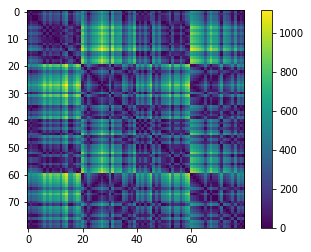

Computing Laplacians for B1056 original unfamiliar...
B1056 E_scaled_burung
B1056 F_scaled_burung
B1056 G_scaled_burung
B1056 H_scaled_burung
Between: 357.72
Within: 191.4452380952381
Diff: 166.27476190476193


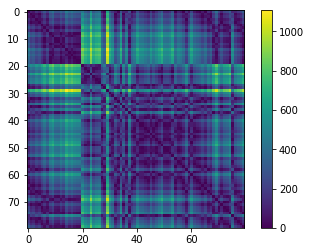

Computing Laplacians for B1056 shuffled familiar...
B1056 B_scaled_burung
B1056 D_scaled_burung
B1056 A_scaled_burung
B1056 C_scaled_burung
Between: 395.75166666666667
Within: 170.8738095238095
Diff: 224.87785714285715


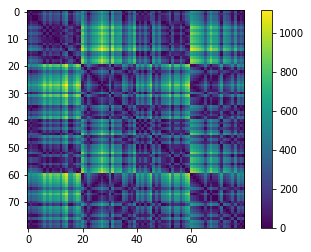

Computing Laplacians for B1056 shuffled unfamiliar...
B1056 E_scaled_burung
B1056 F_scaled_burung
B1056 G_scaled_burung
B1056 H_scaled_burung
Between: 357.72
Within: 191.4452380952381
Diff: 166.27476190476193


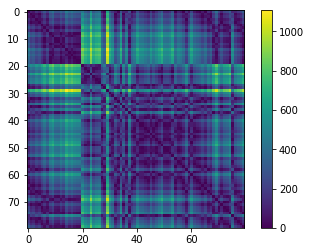

Computing Laplacians for B1235 original familiar...
B1235 F_scaled_burung
B1235 H_scaled_burung
B1235 E_scaled_burung
B1235 G_scaled_burung
Between: 160.23166666666665
Within: 106.51428571428572
Diff: 53.717380952380935


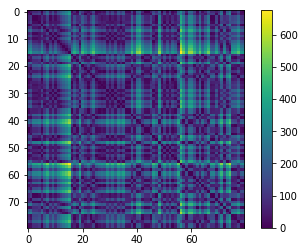

Computing Laplacians for B1235 original unfamiliar...
B1235 A_scaled_burung
B1235 B_scaled_burung
B1235 C_scaled_burung
B1235 D_scaled_burung
Between: 201.38166666666666
Within: 130.35476190476192
Diff: 71.02690476190475


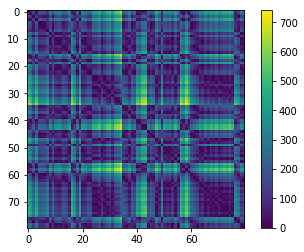

Computing Laplacians for B1235 shuffled familiar...
B1235 F_scaled_burung
B1235 H_scaled_burung
B1235 E_scaled_burung
B1235 G_scaled_burung
Between: 160.23166666666665
Within: 106.51428571428572
Diff: 53.717380952380935


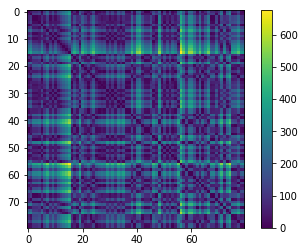

Computing Laplacians for B1235 shuffled unfamiliar...
B1235 A_scaled_burung
B1235 B_scaled_burung
B1235 C_scaled_burung
B1235 D_scaled_burung
Between: 201.38166666666666
Within: 130.35476190476192
Diff: 71.02690476190475


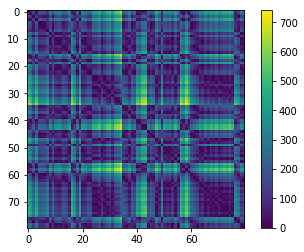

Computing Laplacians for B1083 original familiar...
B1083 N_40k
B1083 P_40k
B1083 M_40k
B1083 O_40k
Between: 273.725
Within: 130.09761904761905
Diff: 143.62738095238097


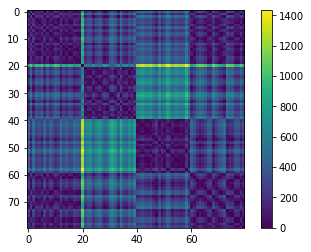

Computing Laplacians for B1083 original unfamiliar...
B1083 I_40k
B1083 J_40k
B1083 K_40k
B1083 L_40k
Between: 236.82166666666666
Within: 168.53571428571428
Diff: 68.28595238095238


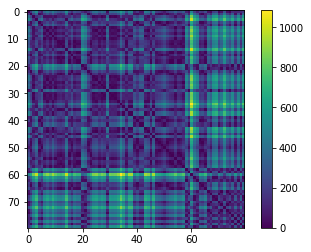

Computing Laplacians for B1083 shuffled familiar...
B1083 N_40k
B1083 P_40k
B1083 M_40k
B1083 O_40k
Between: 273.725
Within: 130.09761904761905
Diff: 143.62738095238097


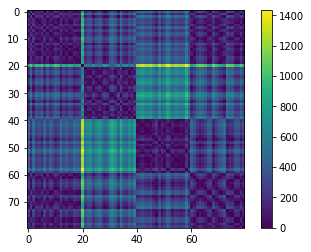

Computing Laplacians for B1083 shuffled unfamiliar...
B1083 I_40k
B1083 J_40k
B1083 K_40k
B1083 L_40k
Between: 236.82166666666666
Within: 168.53571428571428
Diff: 68.28595238095238


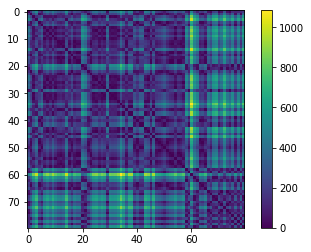

Computing Laplacians for B1083-5 original familiar...
B1083-5 N_40k
B1083-5 P_40k
B1083-5 M_40k
B1083-5 O_40k
Between: 262.2083333333333
Within: 108.58333333333333
Diff: 153.625


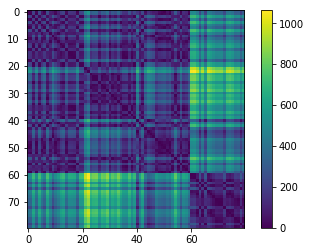

Computing Laplacians for B1083-5 original unfamiliar...
B1083-5 I_40k
B1083-5 J_40k
B1083-5 K_40k
B1083-5 L_40k
Between: 216.57833333333335
Within: 137.48333333333332
Diff: 79.09500000000003


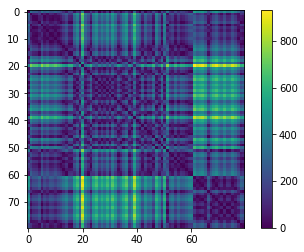

Computing Laplacians for B1083-5 shuffled familiar...
B1083-5 N_40k
B1083-5 P_40k
B1083-5 M_40k
B1083-5 O_40k
Between: 262.2083333333333
Within: 108.58333333333333
Diff: 153.625


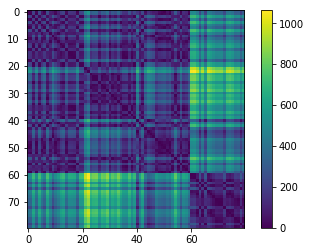

Computing Laplacians for B1083-5 shuffled unfamiliar...
B1083-5 I_40k
B1083-5 J_40k
B1083-5 K_40k
B1083-5 L_40k
Between: 216.57833333333335
Within: 137.48333333333332
Diff: 79.09500000000003


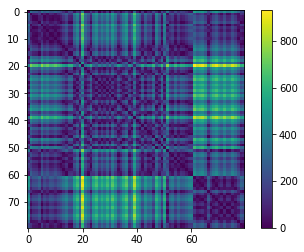

In [65]:
# check difference in total number of spikes
for bird in test_birds:
    for sh in ['original', 'shuffled']:
        for fam in ['familiar', 'unfamiliar']:
            ntrials = 2 # Only do half the trials for each stim
            bird_tensors = poptens[fam][bird]
            SCG = []
            spectra = []
            laplacians_save = []
            print('Computing Laplacians for {} {} {}...'.format(bird, sh, fam))
            for bird_tensor, stim in bird_tensors:
                binmatlist = []
                print(bird, stim)
                ncells, nwin, _ = bird_tensor.shape
                bin_tensor = threshold_poptens(bird_tensor, threshold)
                total_spikes = np.sum(bin_tensor, axis=(0,1))
                laplacians_save.append((bird, stim, list(total_spikes)))
            total_spikes_all= sum([s[2] for s in laplacians_save], [])
            N = len(total_spikes_all)
            #print(total_spikes_all)
            # Precompute M spectra
            pairs = [(i, j) for i in range(N) for j in range(i, N)]
            diff = np.zeros((N, N))
            for (i, j) in pairs:
                #print((total_spikes_all[i], total_spikes_all[j]))
                diff[i, j] = total_spikes_all[i] - total_spikes_all[j]
                
            absdiff = np.abs(diff)
            (btwn, wthn1, wthn2) = compute_withins_vs_between(absdiff, 20, 2)
            wthn = np.concatenate((wthn1, wthn2))
            print('Between:', np.mean(btwn))
            print('Within:', np.mean(wthn))
            print('Diff:', np.mean(btwn) - np.mean(wthn))
            plt.figure()
            plt.imshow((absdiff+absdiff.T))
            plt.colorbar()
            plt.show()
            

array([[-459., -459., -459., ..., -459., -459., -459.],
       [   0., -459., -459., ..., -459., -459., -459.],
       [   0.,    0., -459., ..., -459., -459., -459.],
       ...,
       [   0.,    0.,    0., ..., -459., -459., -459.],
       [   0.,    0.,    0., ...,    0., -459., -459.],
       [   0.,    0.,    0., ...,    0.,    0., -459.]])

In [29]:
test = [[1,2], [3,4]]
sum(test, [])

[1, 2, 3, 4]